In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
from singleVis.vis_models import vis_models
from singleVis.data import ActiveLearningDataProvider
from singleVis.projector import DVIProjector

from config import load_cfg
########################################################################################################################
#                                                     DVI PARAMETERS                                                   #
########################################################################################################################
"""DVI with semantic temporal edges"""
VIS_METHOD = "tdvi" # DeepVisualInsight

2025-07-08 21:24:20.918990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751981060.931520  191819 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751981060.935276  191819 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751981060.946702  191819 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751981060.946712  191819 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751981060.946714  191819 computation_placer.cc:177] computation placer alr

In [33]:
CONTENT_PATH = "/mnt/hdd1/ljiahao/xianglin/SentryCam/ResNet_CIFAR10_ER_CF"

In [34]:
########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################

sys.path.append(CONTENT_PATH)
config = load_cfg(os.path.join(CONTENT_PATH, "config", f"{VIS_METHOD}.yaml"))
print(config)

SETTING = config.SETTING
CLASSES = config.CLASSES
DATASET = config.DATASET
PREPROCESS = config.VISUALIZATION.PREPROCESS
GPU_ID = config.GPU
EPOCH_START = config.EPOCH_START
EPOCH_END = config.EPOCH_END
EPOCH_PERIOD = config.EPOCH_PERIOD
EPOCH_NAME = config.EPOCH_NAME

# Training parameter (subject model)
TRAINING_PARAMETER = config.TRAINING
NET = TRAINING_PARAMETER.NET
LEN = TRAINING_PARAMETER.train_num

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config.VISUALIZATION
SAVE_BATCH_SIZE = VISUALIZATION_PARAMETER.SAVE_BATCH_SIZE
LAMBDA = VISUALIZATION_PARAMETER.LAMBDA
B_N_EPOCHS = VISUALIZATION_PARAMETER.BOUNDARY.B_N_EPOCHS
L_BOUND = VISUALIZATION_PARAMETER.BOUNDARY.L_BOUND
ENCODER_DIMS = VISUALIZATION_PARAMETER.ENCODER_DIMS
DECODER_DIMS = VISUALIZATION_PARAMETER.DECODER_DIMS
S_N_EPOCHS = VISUALIZATION_PARAMETER.S_N_EPOCHS
T_N_EPOCHS = VISUALIZATION_PARAMETER.T_N_EPOCHS
N_NEIGHBORS = VISUALIZATION_PARAMETER.N_NEIGHBORS
PATIENT = VISUALIZATION_PARAMETER.PATIENT
MAX_EPOCH = VISUALIZATION_PARAMETER.MAX_EPOCH
VIS_MODEL = VISUALIZATION_PARAMETER.VIS_MODEL
METRIC = VISUALIZATION_PARAMETER.METRIC

VIS_MODEL_NAME = f"{VIS_METHOD}"
EVALUATION_NAME = f"evaluation_{VIS_MODEL_NAME}"

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

########################################################################################################################
#                                                    TRAINING SETTING                                                  #
########################################################################################################################
# Define data_provider
data_provider = ActiveLearningDataProvider(CONTENT_PATH, net, EPOCH_START, device=DEVICE, classes=CLASSES, iteration_name=EPOCH_NAME, verbose=1)
# Define visualization models
model = vis_models[VIS_MODEL](ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, epoch_name=EPOCH_NAME, device=DEVICE)


CLASSES: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
DATASET: CIFAR10
EPOCH_END: 35
EPOCH_NAME: Epoch
EPOCH_PERIOD: 1
EPOCH_START: 1
GPU: 1
SETTING: normal
TRAINING:
  NET: resnet18
  test_num: 10000
  train_num: 50000
VISUALIZATION:
  ALPHA: 0.0
  BETA: 0.1
  BOUNDARY:
    B_N_EPOCHS: 0
    L_BOUND: 0.4
  DECODER_DIMS: [2, 32, 64, 128, 256, 512]
  Delay: 1
  Delay_time: 32
  ENCODER_DIMS: [512, 256, 128, 64, 32, 2]
  INIT_NUM: 300
  LAMBDA: 1.0
  LAMBDA1: 1.0
  LAMBDA2: 0.3
  MAX_EPOCH: 20
  METRIC: euclidean
  N_NEIGHBORS: 15
  PATIENT: 3
  PREPROCESS: 1
  RESOLUTION: 300
  SAVE_BATCH_SIZE: 5000
  S_N_EPOCHS: 3
  T_N_EPOCHS: 2
  VIS_MODEL: cnAE
Finish initialization...


In [35]:
########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################
from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200)
save_dir = os.path.join(data_provider.content_path, "img")
os.makedirs(save_dir, exist_ok=True)
    
# for epoch in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
#     vis.savefig(epoch, save_dir)

# Identify Catastrophic forgetting

In [36]:
from singleVis.training_dynamics import TD, cross_entropy

In [37]:
# get the idxs of first context
from singleVis.utils import load_labelled_data_index

index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 5), "index.json")
if os.path.exists(index_file):
    index = load_labelled_data_index(index_file)
len(index)

25000

In [38]:
# get loss history
EPOCH_START, EPOCH_END, EPOCH_PERIOD = 1, 35, 1
# epoch, num, 1
loss_history = None

for epoch in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
    representation = data_provider.train_representation_all(epoch)[index]
    labels = data_provider.train_labels_all()[index]
    pred = data_provider.get_pred(epoch, representation)
    loss = cross_entropy(pred, labels, class_num=len(data_provider.classes))

    if loss_history is None:
        loss_history = np.expand_dims(loss, axis=0)
    else:
        loss_history = np.concatenate((loss_history, np.expand_dims(loss, axis=0)), axis=0)
loss_history = np.transpose(loss_history, [1,0])

100%|██████████| 13/13 [00:00<00:00, 5787.70it/s]


100%|██████████| 13/13 [00:00<00:00, 6561.49it/s]


In [39]:
# get loss history
EPOCH_START, EPOCH_END, EPOCH_PERIOD = 1, 35, 1
# epoch, num, 1
valid_loss_history = None

for epoch in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
    representation = data_provider.test_representation(epoch)
    labels = data_provider.test_labels(epoch)
    pred = data_provider.get_pred(epoch, representation)
    loss = cross_entropy(pred, labels, class_num=len(data_provider.classes))

    if valid_loss_history is None:
        valid_loss_history = np.expand_dims(loss, axis=0)
    else:
        valid_loss_history = np.concatenate((valid_loss_history, np.expand_dims(loss, axis=0)), axis=0)
valid_loss_history = np.transpose(valid_loss_history, [1,0])

100%|██████████| 5/5 [00:00<00:00, 5565.69it/s]


100%|██████████| 5/5 [00:00<00:00, 5592.41it/s]


In [40]:
# get visualization trajectory
# epoch, num, dims
position_history = None

for epoch in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
    representation = data_provider.train_representation_all(epoch)[index]
    if position_history is None:
        position_history = np.expand_dims(representation, axis=0)
    else:
        position_history = np.concatenate((position_history, np.expand_dims(representation, axis=0)), axis=0)
position_history = np.transpose(position_history, [1,0,2])


In [41]:
visualization_history = None

for epoch in range(EPOCH_START, EPOCH_END+1, EPOCH_PERIOD):
    representation = data_provider.train_representation_all(epoch)[index]
    embedding = projector.batch_project(epoch, representation)
    if visualization_history is None:
        visualization_history = np.expand_dims(embedding, axis=0)
    else:
        visualization_history = np.concatenate((visualization_history, np.expand_dims(embedding, axis=0)), axis=0)
visualization_history = np.transpose(visualization_history, [1,0,2])

In [42]:
labels = data_provider.train_labels_all()[index]

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

# --- 1. METRIC CALCULATION FUNCTIONS (Input: Trajectory Data) ---
def calculate_dbi_trajectory(trajectories, labels):
    """
    Calculates the Davies-Bouldin Index for each time step in a trajectory.

    Args:
        trajectories (np.array): Shape (N, num_epochs, 2). The 2D embeddings over time.
        labels (np.array): Shape (N,). The class labels for each point.

    Returns:
        np.array: A 1D array of DBI scores, one for each epoch.
    """
    num_epochs = trajectories.shape[1]
    dbi_scores = []
    print("Calculating Davies-Bouldin Index trajectory...")
    for t in range(num_epochs):
        current_embedding = trajectories[:, t, :]
        # Check for edge case of a single cluster, which would crash DBI
        if len(np.unique(labels)) > 1:
            score = davies_bouldin_score(current_embedding, labels)
            dbi_scores.append(score)
        else: # If only one cluster, score is not well-defined. Append previous or 0.
            dbi_scores.append(dbi_scores[-1] if dbi_scores else 0)
    return np.array(dbi_scores)

def calculate_intra_cluster_variance_trajectory(trajectories, labels):
    """
    Calculates the Average Intra-Cluster Variance for each time step in a trajectory.

    Args:
        trajectories (np.array): Shape (N, num_epochs, 2). The 2D embeddings over time.
        labels (np.array): Shape (N,). The class labels for each point.

    Returns:
        np.array: A 1D array of variance scores, one for each epoch.
    """
    num_epochs = trajectories.shape[1]
    variance_scores = []
    print("Calculating Intra-Cluster Variance trajectory...")
    for t in range(num_epochs):
        current_embedding = trajectories[:, t, :]
        class_variances = []
        for c in np.unique(labels):
            class_points = current_embedding[labels == c]
            if len(class_points) > 1:
                centroid = class_points.mean(axis=0)
                variance = np.mean(np.sum((class_points - centroid)**2, axis=1))
                class_variances.append(variance)
        
        # Average the variance across all classes for this epoch
        if class_variances:
            variance_scores.append(np.mean(class_variances))
        else:
            variance_scores.append(variance_scores[-1] if variance_scores else 0)
            
    return np.array(variance_scores)

def calculate_inter_cluster_distance_trajectory(trajectories, labels):
    """
    Calculates the Average Inter-Cluster Distance for each time step.
    A higher value is better. A sharp decrease indicates collapse.
    """
    num_epochs = trajectories.shape[1]
    distance_scores = []
    print("Calculating Inter-Cluster Distance trajectory...")
    unique_labels = np.unique(labels)
    
    if len(unique_labels) < 2:
        return np.zeros(num_epochs) # Metric is undefined for a single cluster

    for t in range(num_epochs):
        current_embedding = trajectories[:, t, :]
        centroids = np.array([current_embedding[labels == c].mean(axis=0) for c in unique_labels])
        
        # Calculate pairwise distances between centroids and take the mean
        if len(centroids) > 1:
            dist_matrix = squareform(pdist(centroids, 'euclidean'))
            # Get sum of upper triangle (to avoid double counting) and normalize
            avg_dist = np.sum(np.triu(dist_matrix)) / (len(centroids) * (len(centroids) - 1) / 2)
            distance_scores.append(avg_dist)
        else:
            distance_scores.append(0)
            
    return np.array(distance_scores)

# --- 2. DYNAMIC THRESHOLDING (This function is unchanged) ---

def find_trigger_epoch(metric_values, epochs, strategy='derivative', higher_is_better=False, burn_in=5, **kwargs):
    """
    Finds the anomaly trigger epoch. Now handles both "lower is better" and "higher is better" metrics.
    """
    if len(metric_values) <= burn_in:
        return -1
    trigger_epoch = -1
    smoothed_metric = np.convolve(metric_values, np.ones(3)/3, mode='same')

    # Condition for an anomaly depends on whether higher or lower is better
    is_anomaly = (lambda current, prev: current < prev) if higher_is_better else (lambda current, prev: current > prev)

    if strategy == 'derivative':
        for i in range(burn_in, len(smoothed_metric)):
            if is_anomaly(smoothed_metric[i], smoothed_metric[i-1]) and is_anomaly(smoothed_metric[i], smoothed_metric[i-2]):
                trigger_epoch = epochs[i]
                break
    
    elif strategy == 'relative_to_best':
        tolerance = kwargs.get('tolerance', 0.2)
        # Find the best score during burn-in
        best_score = np.max(metric_values[:burn_in]) if higher_is_better else np.min(metric_values[:burn_in])
        if abs(best_score) < 1e-9: best_score = 1e-9 if best_score >= 0 else -1e-9

        # Threshold is a degradation from the best score
        threshold = best_score * (1 - tolerance) if higher_is_better else best_score * (1 + tolerance)
        
        for i in range(burn_in, len(metric_values)):
            if is_anomaly(metric_values[i], threshold):
                trigger_epoch = epochs[i]
                break
                
    elif strategy == 'std_dev_zscore':
        window_size = kwargs.get('window_size', 5)
        num_std_devs = kwargs.get('num_std_devs', 2.0)
        if len(metric_values) < burn_in + window_size: return -1
        
        for i in range(burn_in + window_size, len(metric_values)):
            window = metric_values[i-window_size : i]
            mean, std = np.mean(window), np.std(window)
            if std < 1e-9: continue
            
            # Anomaly is being too many std devs away from the mean in the "bad" direction
            threshold = mean - num_std_devs * std if higher_is_better else mean + num_std_devs * std
            
            if is_anomaly(metric_values[i], threshold):
                trigger_epoch = epochs[i]
                break

    return trigger_epoch

# --- 3. MAIN ANALYSIS & PLOTTING FUNCTION ---

def analyze_and_plot_trajectories(
    sentrycam_trajectories, 
    all_labels, 
    loss_trajectory, 
    valid_loss_trajectory,
    scenario_type, 
    trigger_strategy='derivative'
):
    """
    Analyzes pre-computed trajectories using a 2D health space (Inter vs. Intra cluster metrics)
    and generates a comprehensive diagnostic plot.
    """
    num_epochs = sentrycam_trajectories.shape[1]
    epochs = np.arange(1, num_epochs + 1)
    
    print(f"\n--- Analyzing Scenario: '{scenario_type}' with 2D Health Metrics ---")

    # --- Step 1: Calculate both core geometric metric trajectories ---
    intra_variance_traj = calculate_intra_cluster_variance_trajectory(sentrycam_trajectories, all_labels)
    inter_distance_traj = calculate_inter_cluster_distance_trajectory(sentrycam_trajectories, all_labels)

    # --- Step 2: Find trigger epochs for early warning calculation ---
    # The primary anomaly signal for collapse/instability is a drop in inter-cluster distance.
    # We use this as our main SentryCam trigger.
    t_sentry_trigger = find_trigger_epoch(inter_distance_traj, epochs, strategy=trigger_strategy, higher_is_better=True)
    t_loss_trigger = find_trigger_epoch(loss_trajectory, epochs, strategy=trigger_strategy, higher_is_better=False)

    # --- Step 3: Print Quantitative Results ---
    print(f"\n--- Anomaly Detection Results ('{trigger_strategy}' strategy) ---")
    print(f"Loss-based trigger (starts rising) at Epoch: {t_loss_trigger}")
    print(f"SentryCam trigger (Inter-Cluster Distance starts dropping) at Epoch: {t_sentry_trigger}")
    if t_sentry_trigger != -1 and t_loss_trigger != -1:
        early_warning_epochs = t_loss_trigger - t_sentry_trigger
        if early_warning_epochs > 0:
            print(f"SentryCam provided a {early_warning_epochs}-epoch early warning!")

    # --- Step 4: Generate the 2D Cluster Health Trajectory Plot ---
    fig = plt.figure(figsize=(18, 8))
    gs = fig.add_gridspec(1, 2)
    
    # === Panel (a): The new 2D Cluster Health Trajectory ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Panel (a): 2D Cluster Health Trajectory", fontweight='bold')
    ax1.set_xlabel("Intra-Cluster Variance (Worse ->)")
    ax1.set_ylabel("Inter-Cluster Distance (<- Better)")

    # Combine metrics into a list of (x, y) points for plotting
    health_points = np.column_stack((intra_variance_traj, inter_distance_traj))
    
    # Plot the trajectory path, color-coded by epoch
    scatter = ax1.scatter(health_points[:, 0], health_points[:, 1], c=epochs, cmap='viridis', s=40, zorder=3)
    cbar = fig.colorbar(scatter, ax=ax1, orientation='vertical')
    cbar.set_label("Epoch")

    # Draw arrows to show the direction of training
    for i in range(1, len(health_points)):
        ax1.annotate("",
                     xy=health_points[i], xycoords='data',
                     xytext=health_points[i-1], textcoords='data',
                     arrowprops=dict(arrowstyle="->", color="black", alpha=0.4,
                                     shrinkA=5, shrinkB=5,
                                     patchA=None, patchB=None,
                                     connectionstyle="arc3,rad=0.1"))

    # Highlight and label key points
    ax1.plot(health_points[0, 0], health_points[0, 1], 'o', c='red', markersize=10, label='Start (Epoch 1)', zorder=4)
    if t_sentry_trigger != -1:
        trigger_idx = t_sentry_trigger - 1
        ax1.plot(health_points[trigger_idx, 0], health_points[trigger_idx, 1], 'X', c='orange', markersize=12, label=f'SentryCam Alert (Epoch {t_sentry_trigger})', zorder=5)
    
    # Mark the ideal "goal" region
    ideal_x_thresh = np.percentile(intra_variance_traj, 25)
    ideal_y_thresh = np.percentile(inter_distance_traj, 75)
    ax1.axvspan(0, ideal_x_thresh, color='green', alpha=0.1, zorder=0, label='Ideal Region')
    ax1.axhspan(ideal_y_thresh, health_points[:, 1].max() * 1.1, color='green', alpha=0.1, zorder=0)
    
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # === Panel (b): Traditional Loss Curve for Context ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Panel (b): Validation Loss Curve", fontweight='bold')
    ax2.plot(epochs, loss_trajectory, '-o', color='red', label='Training Loss')
    ax2.plot(epochs, valid_loss_trajectory, '-o', color='blue', label='Validation Loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Validation Loss")

    # # === Panel (c): SentryCam View ===
    # epoch_to_plot=7
    # ax = fig.add_subplot(gs[1, 0])
    # emb = sentrycam_trajectories[:, epoch_to_plot - 1, :]
    # scatter = ax.scatter(emb[:, 0], emb[:, 1], c=all_labels, cmap='Spectral', s=5, alpha=0.7)
    # ax.set_title(f"SentryCam View (Epoch {epoch_to_plot})")
    # ax.set_xticks([]); ax.set_yticks([])

    # epoch_to_plot=13
    # ax = fig.add_subplot(gs[1, 1])
    # emb = sentrycam_trajectories[:, epoch_to_plot - 1, :]
    # scatter = ax.scatter(emb[:, 0], emb[:, 1], c=all_labels, cmap='Spectral', s=5, alpha=0.7)
    # ax.set_title(f"SentryCam View (Epoch {epoch_to_plot})")
    # ax.set_xticks([]); ax.set_yticks([])

    # fig.colorbar(scatter, ax=ax, label='Class Label')
    # fig.tight_layout()
    # plt.suptitle(f"Diagnostic Analysis for Scenario: {scenario_type.title()}", fontsize=16, y=1.02)
    # plt.show()
    
    # Annotate with triggers for comparison
    if t_loss_trigger != -1:
        ax2.axvline(x=t_loss_trigger, color='red', linestyle='--', label=f'Loss Alert (Epoch {t_loss_trigger})')
    if t_sentry_trigger != -1:
        ax2.axvline(x=t_sentry_trigger, color='blue', linestyle='--', label=f'SentryCam Alert (Epoch {t_sentry_trigger})')
    
    ax2.legend()
    ax2.grid(True, linestyle='--')
    
    plt.suptitle(f"SentryCam Diagnostic for '{scenario_type.title()}' Scenario", fontsize=16, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [44]:
loss_history.shape, valid_loss_history.shape, visualization_history.shape, labels.shape

((25000, 35), (10000, 35), (25000, 35, 2), (25000,))

In [45]:
loss_history = loss_history.mean(axis=0)
valid_loss_history = valid_loss_history.mean(axis=0)

In [46]:
loss_history

array([0.9406653 , 0.77382548, 0.69084637, 0.59139439, 0.54934909,
       0.50993536, 0.39929911, 0.32383522, 0.35073853, 0.28556915,
       0.22802492, 0.24460224, 0.26569257, 0.22017002, 0.20698519,
       2.11521904, 4.35830013, 4.35194156, 4.63773705, 4.73265883,
       4.89995871, 4.82893402, 5.59025226, 5.98086424, 6.53192638,
       6.49688863, 6.1353213 , 6.06819475, 6.11468026, 6.38191377,
       6.79833681, 8.24448594, 6.14482236, 7.61274556, 6.85668922])


--- Analyzing Scenario: 'forgetting' with 2D Health Metrics ---
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...

--- Anomaly Detection Results ('std_dev_zscore' strategy) ---
Loss-based trigger (starts rising) at Epoch: 16
SentryCam trigger (Inter-Cluster Distance starts dropping) at Epoch: 16


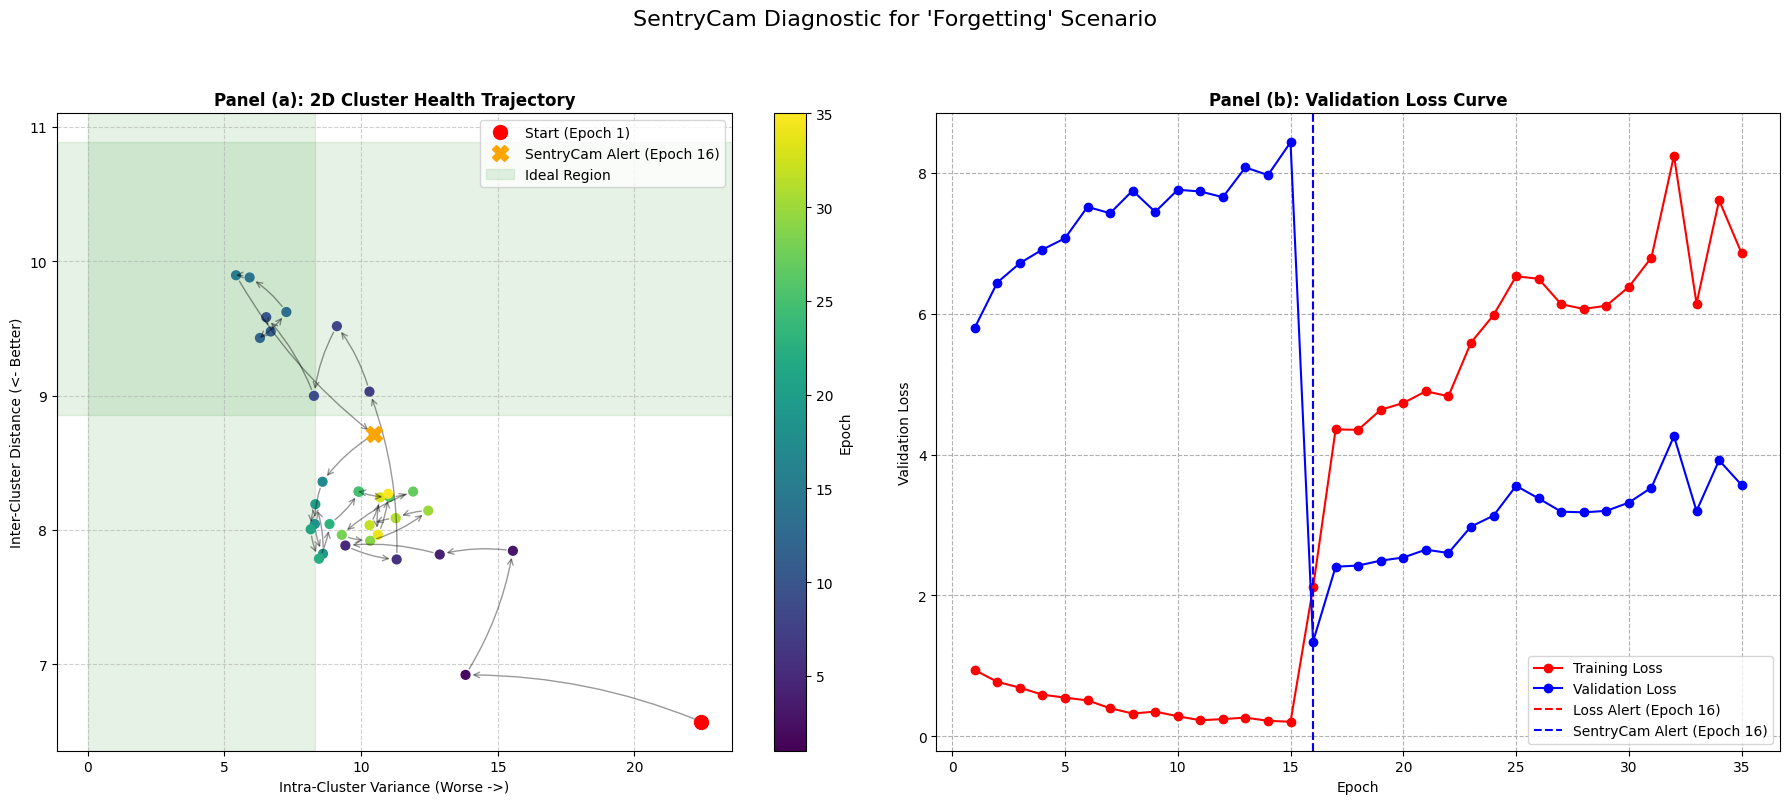

In [50]:
# Forgetting
SCENARIO = 'forgetting'
# SCENARIO = 'unstable'

# STRATEGY = 'derivative'
# STRATEGY = 'relative_to_best'
STRATEGY = 'std_dev_zscore'

# 1. Generate mock data in the specified format

# 2. Analyze the trajectories
analyze_and_plot_trajectories(
    sentrycam_trajectories=visualization_history,
    all_labels=labels,
    loss_trajectory=loss_history,
    valid_loss_trajectory=valid_loss_history,
    scenario_type=SCENARIO,
    trigger_strategy=STRATEGY
)